In [56]:
import random
import numpy as np
import math
import scipy.special
import matplotlib.pyplot as plt

In [57]:
domains = {
    'x1': [i for i in range(0,16)],
    'x2': [i for i in range(0,11)],
    'x3': [i for i in range(0,26)],
    'x4': [i for i in range(0,5)],
    'x5': [i for i in range(0,31)],
}

In [58]:
costos=[164,310,46,111,12]

In [59]:
constraints = {
    ('x1', 'x2'): lambda x1, x2:  costos[0]*x1 <= 3800-costos[1]*x2,
    ('x2', 'x1'): lambda x2, x1:  3800-costos[1]*x2 >= costos[0]*x1,
    ('x3', 'x4'): lambda x3, x4:  costos[2]*x3 <= 2800-costos[3]*x4,
    ('x4', 'x3'): lambda x4, x3:  2800-costos[3]*x4 >= costos[2]*x3,
    ('x3', 'x5'): lambda x3, x5:  costos[2]*x3 <= 3500-costos[4]*x5,
    ('x5', 'x3'): lambda x5, x3:  3500-costos[4]*x5 >= costos[2]*x3,
}

In [60]:
def revise(x, y):
    revised = False
    x_domain = domains[x]
    y_domain = domains[y]
    all_constraints = [
        constraint for constraint in constraints if constraint[0] == x and constraint[1] == y]
    for x_value in x_domain:
        satisfies = False
        for y_value in y_domain:
            for constraint in all_constraints:
                constraint_func = constraints[constraint]
                if constraint_func(x_value, y_value):
                    satisfies = True
        if not satisfies:
            x_domain.remove(x_value)
            revised = True
    return revised

def ac3(arcs):
    queue = arcs[:]
    while queue:
        (x, y) = queue.pop(0)
        revised = revise(x, y)
        if revised:
            neighbors = [neighbor for neighbor in arcs if neighbor[1] == x]
            queue = queue + neighbors

In [61]:
arcs = [
    ('x1', 'x2'), ('x2', 'x1'),
    ('x3', 'x4'), ('x4', 'x3'),
    ('x3', 'x5') ,('x5', 'x3'),
]

In [62]:
ac3(arcs)

In [63]:
def maximizar(x):
    x1,x2,x3,x4,x5=x
    return 67*x1+91*x2+43*x3+71*x4+23*x5

In [64]:
def minimizar(x):
    x1,x2,x3,x4,x5=x
    return 164*x1+310*x2+46*x3+111*x4+12*x5

In [65]:
def restricciones(x):
    x1,x2,x3,x4,x5=x
    return (0<= x1 and x1<=15 and 0<=x2 and x2<=10 and 0<=x3 and x3<=25 and 0<=x4 and x4<=4 and 0<=x5 and x5<=30 \
            and 164*x1+310*x2<=3800 and 46*x3+111*x4<= 2800 and 46*x3+13*x5<= 3500)

In [66]:
def scalarizing(x, wmax, wmin):
    cap=5000
    fracmax=(maximizar(x))/3418
    fracmin=(cap-(minimizar(x))) / (cap-0)
    return wmin*fracmax + wmax*fracmin

In [67]:
def Cl() -> float:
    return random.uniform(0.674,1.5)

In [68]:
def gliding():
    ro = 1.204#𝜌
    hg = 8
    V = 5.25
    S = 154
    Gc = 1.9
    Cd = 0.60
    L = 1 / 2 * (ro * (Cl()) * (V**2) * S)
    D = 1 / 2 * (ro * (V**2) * S * Cd)
    artc = np.arctan(D / L)
    dg = hg / np.tan(artc)
    sf = 18
    return dg / sf


In [69]:
def rho():
    beta=1.5
    return ((scipy.special.gamma(beta+1)*np.sin((math.pi*beta)/2))/ \
     (scipy.special.gamma((1+beta)/2)*beta*(2)**((beta-1)/2)))**(1/beta)

In [70]:
lower_band=[domains[f"x{i+1}"][0] for i in range(len(domains.keys()))]
upper_band=[domains[f"x{i+1}"][-1] for i in range(len(domains.keys()))]

In [71]:
def levy():
    beta = 1.5
    sigma = (scipy.special.gamma(1 + beta) * np.sin(np.pi * beta / 2) /
             (scipy.special.gamma((1 + beta) / 2) * beta * 2**((beta - 1) / 2)))**(1 / beta)
    u = np.random.normal(0, sigma, size=len(lower_band)) 
    v = np.random.normal(0, 1, size=len(lower_band)) 
    step = u / np.abs(v)**(1 / beta)
    return 0.01 * step

In [72]:
def randomloc(index):
    return lower_band[index] + levy()[index] * (upper_band[index] - lower_band[index]) 

In [73]:
def actualizar_valores(i, ref_vector, Pdp):
    for u, v in enumerate(i):
        if random.uniform(0, 1) >= Pdp:
            new_value = v + gliding() * 1.9 * (ref_vector[u] - v)
        else:
            new_value = randomloc(u)
        i[u] = new_value
    return np.clip(i, lower_band, upper_band) 

In [74]:
def Smin(t,maxiter):
    return (10 * 10**-6)/(365**(t/(maxiter/2.5)))

peor fitness = hickory \
los siguientes 3 = bellota a hickory \
el rest = normal

In [75]:
def main(maxiter,popsize,wmax,wmin):
    FS=[]
    for i in range(popsize):
        while True:
            aux=[random.uniform(lower_band[j], upper_band[j]) for j in range(len(lower_band))]
            if restricciones(aux):
                break
        FS.append(aux)

    fitness_values = [scalarizing(ind,wmax,wmin) for ind in FS]

    FS = [x for _, x in sorted(zip(fitness_values, FS), key=lambda pair: pair[0])]

    trees = [1]
    if popsize > 1:
        trees.extend([2] * min(popsize - 1, 3))
    if popsize > 4:
        trees.extend(random.randint(3, 4) for _ in range(popsize - 4))
    Pdp=0.01

    for iterable in range(maxiter):
        Sc = []
        for j, i in enumerate(FS[1:4]):
            resta = 0
            while True:
                FS[j + 1] = actualizar_valores(i, FS[0], Pdp)
                if restricciones(FS[j+1]):
                    break
            resta = np.array(i) - np.array(FS[0])
            resta = np.sqrt(np.sum(resta**2))
            Sc.append(resta)

        for idx, j in enumerate(FS[4:]):
            if trees[idx + 4] == 3:
                ref_vector = random.choice(FS[1:4])
            else:
                ref_vector = FS[0]
            while True:
                FS[idx + 4] = actualizar_valores(j, ref_vector, Pdp)
                if restricciones(FS[idx + 4]):
                    break
            
        for idx, value in enumerate(Sc):
            if value < Smin(iterable, maxiter):
                while True:
                    for i in range(len(FS[idx + 1])):
                        FS[idx + 1][i] = randomloc(i)
                    if restricciones(FS[idx + 1]):
                        break
                FS[idx + 1] = np.clip(FS[idx + 1], lower_band, upper_band)

        fitness_values = [scalarizing(ind,wmax,wmin) for ind in FS]

        FS = [x for _, x in sorted(zip(fitness_values, FS), key=lambda pair: pair[0])]

        trees = [1]
        if popsize > 1:
            trees.extend([2] * min(popsize - 1, 3))
        if popsize > 4:
            trees.extend(random.randint(3, 4) for _ in range(popsize - 4))
            
    return FS

In [76]:
repeticiones=50
resultados={}
for i in np.arange(0.0, 1.1, 0.1):
    print(f"{i}-{1-i}")
    resultados[f"{i}-{1-i}"]=[]
    for j in range(repeticiones):
        FS=main(100,10,i,1-i)
        resultados[f"{i}-{1-i}"].append([maximizar(FS[0]),minimizar(FS[0])])

0.0-1.0
0.1-0.9
0.2-0.8
0.30000000000000004-0.7
0.4-0.6
0.5-0.5
0.6000000000000001-0.3999999999999999
0.7000000000000001-0.29999999999999993
0.8-0.19999999999999996
0.9-0.09999999999999998
1.0-0.0


In [77]:
resultados

{'0.0-1.0': [[0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0]],
 '0.1-0.9': [[0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0

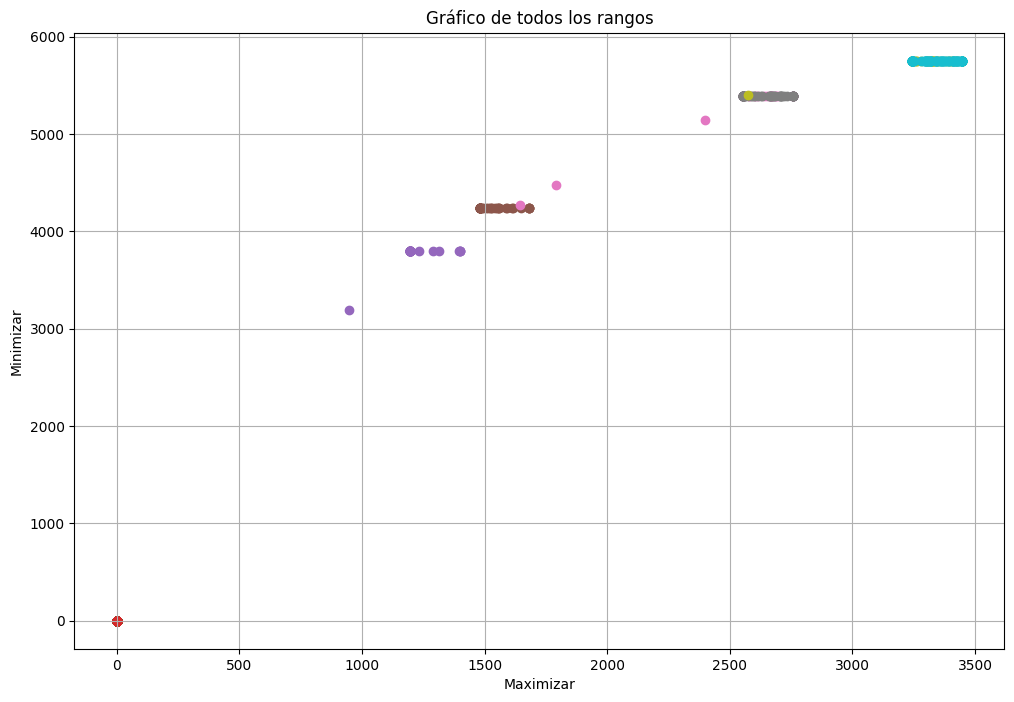

In [80]:
plt.figure(figsize=(12, 8))
plt.title('Gráfico de todos los rangos')
plt.xlabel('Maximizar')
plt.ylabel('Minimizar')

# Diferentes colores para cada rango
colors = plt.get_cmap('tab10', len(resultados))

# Iterar sobre cada conjunto de datos y agregar al gráfico
for idx, (key, values) in enumerate(resultados.items()):
    x_values = [v[0] for v in values]
    y_values = [v[1] for v in values]
    
    plt.scatter(x_values, y_values, label=f'Rango {key}', color=colors(idx))

# Mostrar leyenda y cuadrícula
# plt.legend()
plt.grid(True)
plt.show()